## Fundamentals of Social Data Science
# Week 4 Day 1 Lab. Classification 

In this lab, you will be encouraged to explore your subreddits of choice using multinomial naive bayes and k-means classifications. Determine which one is more suitable using accuracy scores. Use both the TfIDFVectorizer and the CountVectorizer. 

Consider the use of stop words and lemmatisation. 

1. Plot the documents using t-SNE and then color the documents according the most accurate solution. 
2. For Naive Bayes report the 5 most informative terms per solution.  
* Would you be able to report the 5 most informative terms with k-means? This would be a bit far out for this lecture but if you are adventurous you can explore approaches like k-nearest neighbors using the centroids (as in report the 5 nearest neighbors to the centroid for each of the k solutions). 

There is only limited example code for this exercise. It is up to you to stitch together what you have learned as well as potentially draw upon external sources. On Wednesday we will provide an example solution.

Some guidance: 
1. Transform your headlines into a list similar to the walkthrough: [("headline (and maybe selftext)", "subreddit_label"), ("next headline", "next subreddit_label")]
 * Create one long list for all three subreddits to send to the Vectorizer. This is different to what I showed in Week 3 Day 3 where we had a separate vectorizer for each subreddit. To help you out I've started some code that creates a DataFrame for all the subs. 
2. Consider your tokenization. Will you use stop words or not? 
3. Consider plotting the classification on t-SNE to get some intuitions for how the solution maps out visually. 
4. Remember, are you classifying the documents using the terms? Or classifying the terms using the documents? Be careful with how you set this up. Notice that in the examples in the walkthrough we were classifying the documents using the terms. 
5. Consider the structure of this repository. Will you want to place some code for a plotting function in the `analysis.py`? What about creating a function under `text_processor.py` to transform the reddit data into the data structure needed. You can do everything in this Jupyter lab notebook but you should use this opportunity to think about how you might make use of this structure in order to help keep your code tidy. 


In [1]:
import os
import pickle
from models.reddit_scraper import RedditScraper
from config.settings import USER_AGENT
from utils.analysis import *

scraper = RedditScraper(USER_AGENT)
subs_of_interest = ['AskMen', 'AskWomen', 'TooAfraidtoask']

posts_list = []


for sub in subs_of_interest:    
    posts = scraper.get_subreddit_posts(sub, limit=1000, cache=True)
        # Get posts for each subreddit
    df = create_posts_dataframe(posts)
        # Create a dataframe from the posts
    df['subreddit'] = sub
        # Add a column for the subreddit name
    posts_list.append(df)
        # Append the dataframe to the list


# Combine all 3 dataframes into one
posts_df = pd.concat(posts_list)

# Reset the index
posts_df = posts_df.reset_index(drop=True)


Fetching posts from https://api.reddit.com/r/AskMen/new
Response keys: dict_keys(['kind', 'data'])
Fetching posts from https://api.reddit.com/r/AskWomen/new
Response keys: dict_keys(['kind', 'data'])
Fetching posts from https://api.reddit.com/r/TooAfraidtoask/new
Response keys: dict_keys(['kind', 'data'])


## Define corpus and create TF-IDF Matrix

In [2]:
# Import pre-requisite modules

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
# Define corpus

posts_df["all_text"] = posts_df["title"] + " " + posts_df["selftext"]

# Clean the text
posts_df["processed_all_text"] = posts_df["all_text"].apply(preprocess_text)

corpus_text = [doc for doc in posts_df['processed_all_text']]
corpus_labels = [doc for doc in posts_df['subreddit']]


In [4]:
# Create sparse TF-IDF Matrix

# Define vectorizer
vectorizer = TfidfVectorizer(min_df=2)
# vectorizer = TfidfVectorizer(min_df=2, stop_words='english')

# Fit and transform the vectorizer on our corpus into TF-IDF
tfifd_matrix = vectorizer.fit_transform(corpus_text)

# Perform Naive Bayes Classifier

In [5]:

# Split data for NBC
X_train, X_test, y_train, y_test = train_test_split(
    tfifd_matrix, corpus_labels, test_size=0.3, random_state=42
)

print(X_train.shape, X_test.shape) 
# print(X_train.toarray())
print(len(y_train), y_train)
print(len(y_test), y_test)

(210, 999) (90, 999)
210 ['AskWomen', 'AskWomen', 'AskMen', 'TooAfraidtoask', 'AskMen', 'AskMen', 'AskWomen', 'AskWomen', 'TooAfraidtoask', 'AskMen', 'TooAfraidtoask', 'AskMen', 'AskMen', 'AskWomen', 'TooAfraidtoask', 'TooAfraidtoask', 'AskWomen', 'AskMen', 'AskWomen', 'AskMen', 'AskWomen', 'TooAfraidtoask', 'AskMen', 'TooAfraidtoask', 'TooAfraidtoask', 'AskWomen', 'AskWomen', 'TooAfraidtoask', 'AskWomen', 'TooAfraidtoask', 'AskMen', 'AskWomen', 'AskWomen', 'AskWomen', 'AskWomen', 'TooAfraidtoask', 'AskMen', 'AskWomen', 'AskWomen', 'TooAfraidtoask', 'AskWomen', 'AskWomen', 'AskWomen', 'AskWomen', 'TooAfraidtoask', 'TooAfraidtoask', 'AskWomen', 'AskWomen', 'AskWomen', 'AskMen', 'AskWomen', 'AskWomen', 'AskWomen', 'AskWomen', 'TooAfraidtoask', 'TooAfraidtoask', 'AskWomen', 'AskMen', 'AskMen', 'AskMen', 'TooAfraidtoask', 'AskWomen', 'TooAfraidtoask', 'AskWomen', 'TooAfraidtoask', 'TooAfraidtoask', 'TooAfraidtoask', 'AskMen', 'AskWomen', 'AskMen', 'TooAfraidtoask', 'AskWomen', 'AskMen', 'A

In [6]:
# Naive Bayes Classification
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
nbc_pred = nbc.predict(X_test)

# Analyze results
print("Naive Bayes Classification Results:")
print(classification_report(y_test, nbc_pred))

Naive Bayes Classification Results:
                precision    recall  f1-score   support

        AskMen       0.61      0.54      0.58        35
      AskWomen       0.69      0.64      0.67        28
TooAfraidtoask       0.48      0.59      0.53        27

      accuracy                           0.59        90
     macro avg       0.60      0.59      0.59        90
  weighted avg       0.60      0.59      0.59        90



Summarise NBC results: 

The features that are unique to AskWomen are good predictors of whether a text belongs to the 'AskWomen' sub-reddit




# Perform K-Means Classifier

In [7]:
# Import pre-requisite modules

from sklearn.cluster import KMeans

import seaborn as sns

In [8]:
# K-Means Clustering

# Create and fit the k-means model
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(tfifd_matrix)

# Use t-SNE after K-Means to reduce dimenstionality for visualisation

In [9]:
# Convert TD-IDF Matrix into dense array

tfifd_dense_array = tfifd_matrix.toarray()

In [10]:
# Define t-SNE for dimensionality reduction
# Obtain coordinates for tsne plot (compressed to 2D)

tsne = TSNE(n_components=2,
                    perplexity=min(30, len(corpus_labels)-1),
                    random_state=42,
                    metric='cosine')

tfidf_matrix_2d = tsne.fit_transform(tfifd_dense_array)

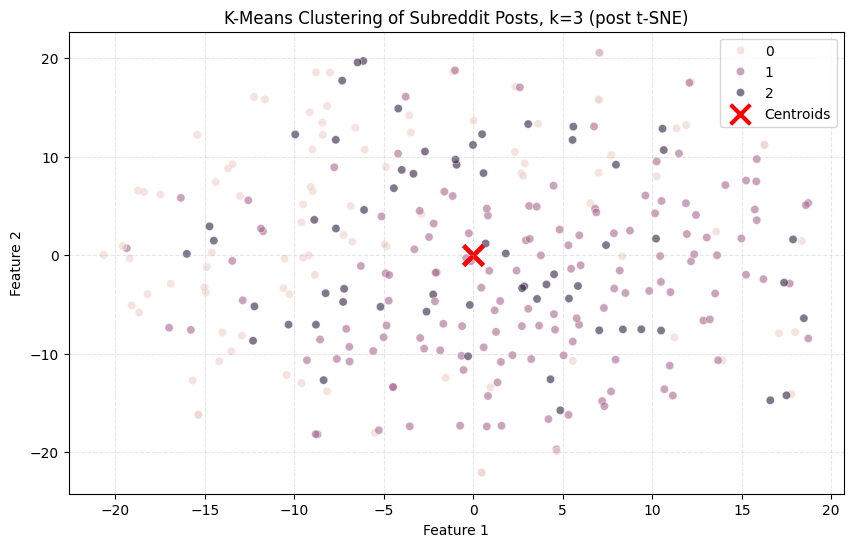


Cluster Centers:
Cluster 0: [0.         0.         0.         0.0039789  0.00228397 0.
 0.         0.         0.         0.         0.         0.
 0.00514782 0.         0.         0.         0.00674673 0.
 0.00310638 0.0017016  0.         0.00352574 0.         0.01207617
 0.         0.         0.         0.         0.         0.
 0.0036165  0.00110245 0.         0.00661968 0.0117475  0.00369561
 0.         0.00613949 0.00310638 0.         0.         0.
 0.         0.         0.00309913 0.         0.00928407 0.
 0.         0.00186082 0.         0.         0.         0.
 0.0017936  0.0017936  0.         0.0057928  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00141885 0.
 0.         0.         0.         0.00147116 0.         0.
 0.0039822  0.         0.         0.         0.         0.
 0.00115071 0.         0.00294704 0.         0.         0.00715535
 0.         0.         0.         0.00450121 0.         0.0024

In [11]:
# Create general visualisation

fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(x=tfidf_matrix_2d[:, 0], y=tfidf_matrix_2d[:, 1], alpha=0.6, hue=cluster_labels)

ax.set_title("K-Means Clustering of Subreddit Posts, k=3 (post t-SNE)")
ax.grid(True, linestyle='--', alpha=0.3)

# Plot the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], 
           kmeans.cluster_centers_[:, 1], 
           c='red', 
           marker='x', 
           s=200, 
           linewidth=3, 
           label='Centroids')

# plt.title('K-means Clustering (k=3)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Print the cluster centers
print("\nCluster Centers:")
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i}: {center}")

# Print inertia (sum of squared distances to closest centroid)
print(f"\nInertia: {kmeans.inertia_:.2f}")

Summarise k-Means results